## Знакомство с GDAL/OGR Python API, часть 2

## Поехали разбирать важные принципы дальше!

In [19]:
# Импортируем сами библиотеки
import gdal
import ogr

Визуализация данных - собираем цветные композиты

Мы знаем, что у нас много каналов и 2, 3 и 4 соответстуют отраженному сигналу в синем, зелёном и красном диапазонах длин волн соответственно. Можно ли сделать композит в естественных цветах? Конечно!


In [28]:
# библиотека для визуалиазации
import matplotlib.pyplot as plt

# многоканальный растр
landsat_ds = gdal.Open('landsat/landsat8_bands_1_to_7.tif')

# Клеим RGB (каналы 4-3-2)
red_band_array = landsat_ds.GetRasterBand(4).ReadAsArray()
green_band_array = landsat_ds.GetRasterBand(3).ReadAsArray()
blue_band_array = landsat_ds.GetRasterBand(2).ReadAsArray()

In [21]:
# что мы имеем в каждой? Давайте посмотрим
print (red_band_array)

[[8306 8090 7826 ... 7383 7274 7268]
 [8364 8217 7830 ... 7275 7215 7139]
 [8175 8243 8172 ... 7338 7317 7111]
 ...
 [7387 7695 7479 ... 8301 8393 8452]
 [7563 7753 8085 ... 8324 8178 8565]
 [7736 7763 7769 ... 8901 8255 8403]]


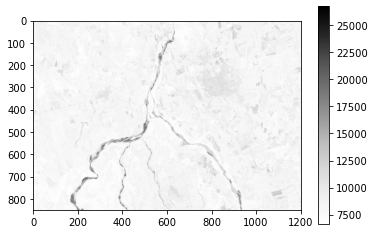

In [25]:
plt.close()
plt.imshow(red_band_array, cmap='Greys')
plt.colorbar()
plt.show()

In [27]:
print (red_band_array[0][0])
print (green_band_array[0][0])
print (blue_band_array[0][0])

8306
8744
9168


In [31]:
# Для начала соберем RGB матрицу. Это делается одной командой!
landsat_rgb = np.dstack([red_band_array,green_band_array,blue_band_array])
print (landsat_rgb.shape)
print (landsat_rgb)

(850, 1203, 3)
[[[8306 8744 9168]
  [8090 8732 9042]
  [7826 8670 8950]
  ...
  [7383 8201 8893]
  [7274 8171 8827]
  [7268 8148 8844]]

 [[8364 8765 9131]
  [8217 8818 9101]
  [7830 8649 8949]
  ...
  [7275 8143 8836]
  [7215 8115 8863]
  [7139 8074 8804]]

 [[8175 8593 9101]
  [8243 8857 9149]
  [8172 8738 9089]
  ...
  [7338 8192 8883]
  [7317 8169 8876]
  [7111 8097 8777]]

 ...

 [[7387 8164 8613]
  [7695 8346 8727]
  [7479 8206 8660]
  ...
  [8301 8813 9103]
  [8393 8867 9172]
  [8452 8841 9139]]

 [[7563 8217 8676]
  [7753 8305 8770]
  [8085 8513 8900]
  ...
  [8324 8862 9087]
  [8178 8841 9068]
  [8565 9006 9261]]

 [[7736 8258 8751]
  [7763 8304 8745]
  [7769 8391 8798]
  ...
  [8901 9083 9404]
  [8255 8851 9059]
  [8403 8983 9152]]]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


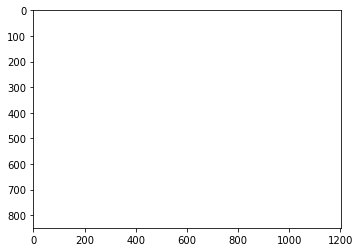

In [32]:
plt.close()
plt.imshow(landsat_rgb)
plt.show()

Возникла проблема - такие данные визуализировать не выходит. Для визуализации их надо предварительно нормализовать - то есть привести к диапазону от 0 до 1

In [33]:
# описываем функцию, которая будет нормализовать значения канала в диапазон от 0 до 1
def normalize(input_band):
    min_value, max_value = input_band.min()*1.0, input_band.max()*1.0
    return ((input_band*1.0 - min_value*1.0)/(max_value*1.0 - min_value))

# вызываем эту функцию для всех наших трёх каналов
red_band_array_normalized = normalize(red_band_array)
green_band_array_normalized = normalize(green_band_array)
blue_band_array_normalized = normalize(blue_band_array)

#посмотрим на какой-нибудь канал
print(blue_band_array_normalized)

[[0.06743105 0.05732842 0.04995189 ... 0.04538165 0.0400898  0.04145285]
 [0.0644644  0.06205901 0.04987171 ... 0.04081142 0.04297627 0.03824567]
 [0.06205901 0.06590763 0.06109686 ... 0.04457986 0.0440186  0.03608082]
 ...
 [0.02293137 0.03207184 0.02669981 ... 0.06221937 0.06775176 0.06510584]
 [0.02798268 0.03551956 0.04594291 ... 0.0609365  0.05941309 0.07488775]
 [0.03399615 0.03351507 0.03776459 ... 0.08635343 0.05869147 0.06614817]]


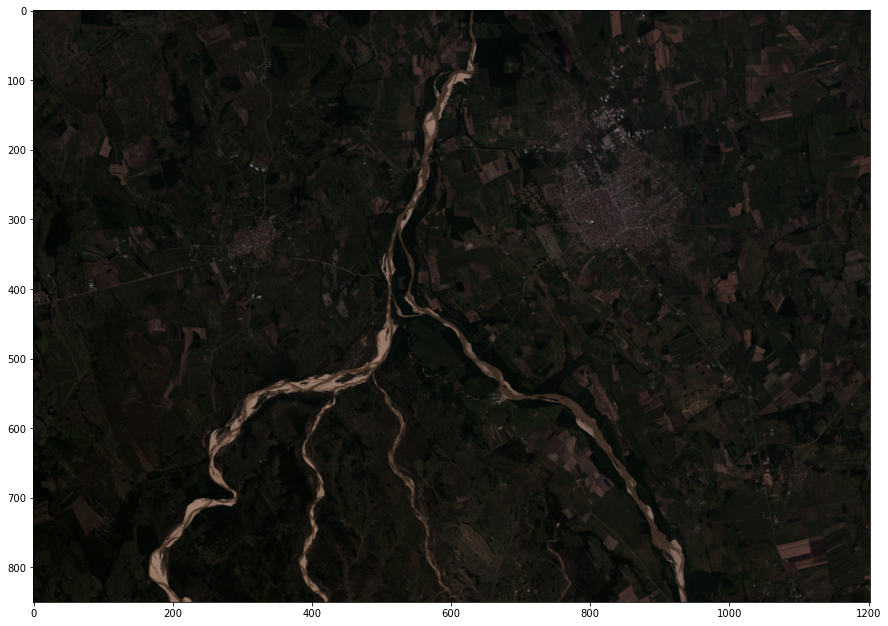

In [36]:
# собираем ещё один композит
landsat_rgb_normalized = np.dstack([red_band_array_normalized,green_band_array_normalized,blue_band_array_normalized])

# заодно настроим размер выводимой картинки
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15,15)

plt.close()
plt.imshow(landsat_rgb_normalized)
plt.show()

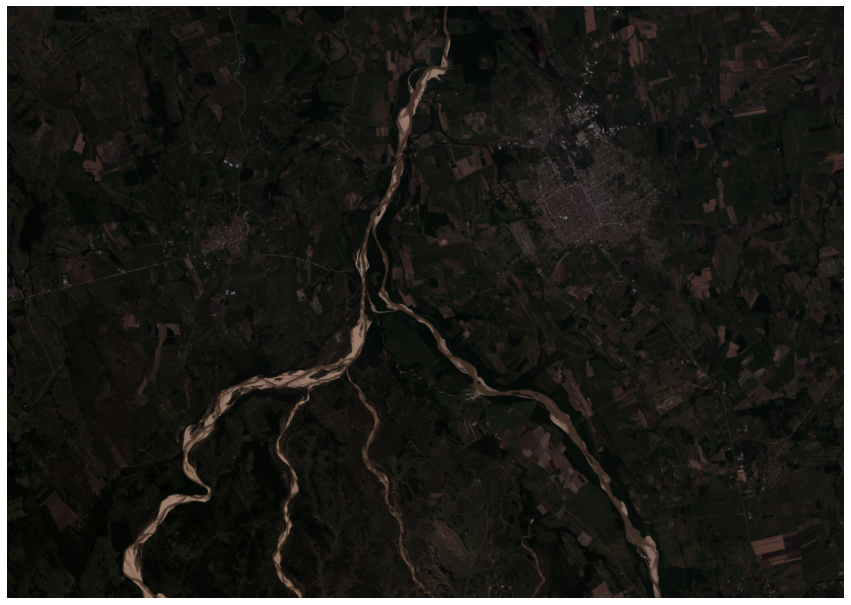

In [39]:
# можно вместо вывода сохранить картинку в файл
plt.close()
plt.imshow(landsat_rgb_normalized)
plt.axis('off')
plt.savefig('landsat/landsat_rgb.png',bbox_inches='tight', pad_inches=0)

## Откуда мы взяли многоканальный растр? Давайте попробуем его собрать из отдельных каналов

In [40]:
# исходные растры
b2_ds = gdal.Open('landsat/b2.tif')
b3_ds = gdal.Open('landsat/b3.tif')
b4_ds = gdal.Open('landsat/b4.tif')

In [44]:
# создаем новый датасет!

# 1. создаем драйвер
driver = gdal.GetDriverByName('GTiff')

# 2. создаем сам набор данных, копируя основные метаданные из любого одиночного канала
new_dataset = driver.Create('landsat/composite.tif', b2_ds.RasterXSize, b2_ds.RasterYSize, 3, b2_ds.GetRasterBand(1).DataType)

# также берём из исходника информацию об СК и привязке
new_dataset.SetProjection(b2_ds.GetProjection())
new_dataset.SetGeoTransform(b2_ds.GetGeoTransform())

# записываем матрицы значений в каждый канал
new_dataset.GetRasterBand(1).WriteArray(b2_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(2).WriteArray(b3_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(3).WriteArray(b4_ds.GetRasterBand(1).ReadAsArray())

# удаляя созданную переменную мы заставляем GDAL записать файл на диск
del new_dataset

В порядке развлечения - а давайте установим другую ГеоТрансформацию!

In [47]:
new_dataset = driver.Create('landsat/composite_wrong.tif', b2_ds.RasterXSize, b2_ds.RasterYSize, 3, b2_ds.GetRasterBand(1).DataType)

new_dataset.SetProjection(b2_ds.GetProjection())
new_dataset.SetGeoTransform((452845.0, 60.0, 0.0, -1999245.0, 0.0, -60.0))

new_dataset.GetRasterBand(1).WriteArray(b2_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(2).WriteArray(b3_ds.GetRasterBand(1).ReadAsArray())
new_dataset.GetRasterBand(3).WriteArray(b4_ds.GetRasterBand(1).ReadAsArray())

del new_dataset

## Следующий важный раздел - растровая арифметика

In [48]:
landsat_ds = gdal.Open('landsat/landsat8_bands_1_to_7.tif')

# Берем два канала - красный и ближний ИК
red_band_array = landsat_ds.GetRasterBand(4).ReadAsArray()
nir_band_array = landsat_ds.GetRasterBand(5).ReadAsArray()

In [49]:
# С этими матрицами можно вытворять всё что угодно. Например, умножим все значения на 2
print(red_band_array*2)

[[16612 16180 15652 ... 14766 14548 14536]
 [16728 16434 15660 ... 14550 14430 14278]
 [16350 16486 16344 ... 14676 14634 14222]
 ...
 [14774 15390 14958 ... 16602 16786 16904]
 [15126 15506 16170 ... 16648 16356 17130]
 [15472 15526 15538 ... 17802 16510 16806]]


In [50]:
# операции между матрицами также возможны, сложим их:
print (red_band_array + nir_band_array)

[[24183 25581 26462 ... 21879 21955 21882]
 [24588 26029 26024 ... 22090 22490 22788]
 [23723 25820 25301 ... 22418 22401 23748]
 ...
 [23824 23604 23153 ... 22824 22992 23216]
 [22466 22114 23199 ... 22932 22893 23449]
 [21993 22564 23099 ... 23820 22948 23551]]


In [51]:
# Посчитаем NDVI по несложной формуле
ndvi_array = (nir_band_array - red_band_array) / (nir_band_array + red_band_array)
print (ndvi_array)

[[0.31307117 0.36749932 0.40851032 ... 0.32510627 0.3373719  0.33570972]
 [0.31966813 0.3686273  0.39824777 ... 0.34133092 0.3583815  0.37344216]
 [0.31079543 0.36150271 0.35401763 ... 0.34534749 0.34672559 0.40112852]
 ...
 [0.37986904 0.34799187 0.35394981 ... 0.27260778 0.26991997 0.27188146]
 [0.32671593 0.29881523 0.3029872  ... 0.27402756 0.2855458  0.26947844]
 [0.29650343 0.31191278 0.32733019 ... 0.25264484 0.28054732 0.28639973]]


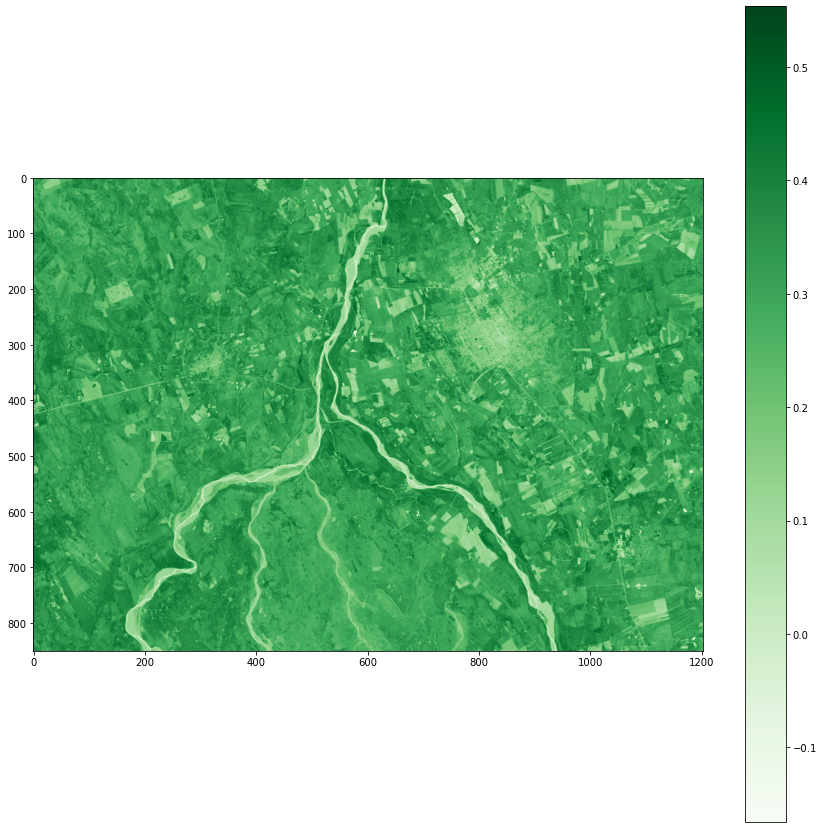

In [53]:
plt.close()
plt.imshow(ndvi_array, cmap='Greens')
plt.colorbar()
plt.show()

На самом деле здесь нам доступны вообще любые операции над матрицами - вплоть до их "усваивания" в сверточные нейронные сети.

In [ ]:
# распространенный подход - построение бинарных масок по пороговым значениям:
ndvi_array [ndvi_array >= 0.4] = 1
ndvi_array [ndvi_array < 0.4] = 0

In [56]:
print (ndvi_array)

[[0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


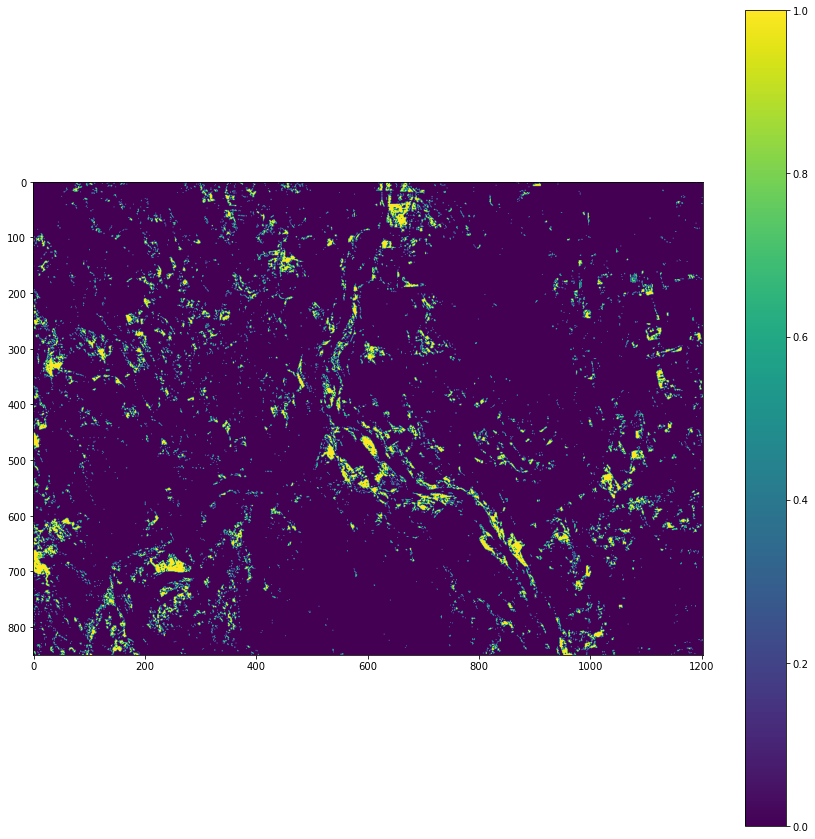

In [55]:
plt.close()
plt.imshow(ndvi_array)
plt.colorbar()
plt.show()

## Запуск утилит GDAL через Python API

In [57]:
# Вся мощь основных утилит GDAL доступна нативно через python

In [59]:
gdal.Translate?

Signature: gdal.Translate(destName, srcDS, **kwargs)
Docstring:
Convert a dataset.
Arguments are :
  destName --- Output dataset name
  srcDS --- a Dataset object or a filename
Keyword arguments are :
  options --- return of gdal.TranslateOptions(), string or array of strings
  other keywords arguments of gdal.TranslateOptions()
If options is provided as a gdal.TranslateOptions() object, other keywords are ignored. 
File:      ~/miniconda3/envs/geoenv3/lib/python3.8/site-packages/osgeo/gdal.py
Type:      function


In [60]:
gdal.Warp?

Signature: gdal.Warp(destNameOrDestDS, srcDSOrSrcDSTab, **kwargs)
Docstring:
Warp one or several datasets.
Arguments are :
  destNameOrDestDS --- Output dataset name or object
  srcDSOrSrcDSTab --- an array of Dataset objects or filenames, or a Dataset object or a filename
Keyword arguments are :
  options --- return of gdal.WarpOptions(), string or array of strings
  other keywords arguments of gdal.WarpOptions()
If options is provided as a gdal.WarpOptions() object, other keywords are ignored. 
File:      ~/miniconda3/envs/geoenv3/lib/python3.8/site-packages/osgeo/gdal.py
Type:      function


In [61]:
gdal.Rasterize?

Signature: gdal.Rasterize(destNameOrDestDS, srcDS, **kwargs)
Docstring:
Burns vector geometries into a raster
Arguments are :
  destNameOrDestDS --- Output dataset name or object
  srcDS --- a Dataset object or a filename
Keyword arguments are :
  options --- return of gdal.RasterizeOptions(), string or array of strings
  other keywords arguments of gdal.RasterizeOptions()
If options is provided as a gdal.RasterizeOptions() object, other keywords are ignored. 
File:      ~/miniconda3/envs/geoenv3/lib/python3.8/site-packages/osgeo/gdal.py
Type:      function


In [62]:
# Можно запросить подробности про параметры каждой
gdal.WarpOptions?

Signature:
gdal.WarpOptions(
    options=None,
    format=None,
    outputBounds=None,
    outputBoundsSRS=None,
    xRes=None,
    yRes=None,
    targetAlignedPixels=False,
    width=0,
    height=0,
    srcSRS=None,
    dstSRS=None,
    coordinateOperation=None,
    srcAlpha=False,
    dstAlpha=False,
    warpOptions=None,
    errorThreshold=None,
    warpMemoryLimit=None,
    creationOptions=None,
    outputType=0,
    workingType=0,
    resampleAlg=None,
    srcNodata=None,
    dstNodata=None,
    multithread=False,
    tps=False,
    rpc=False,
    geoloc=False,
    polynomialOrder=None,
    transformerOptions=None,
    cutlineDSName=None,
    cutlineLayer=None,
    cutlineWhere=None,
    cutlineSQL=None,
    cutlineBlend=None,
    cropToCutline=False,
    copyMetadata=True,
    metadataConflictValue=None,
    setColorInterpretation=False,
    overviewLevel='AUTO',
    callback=None,
    callback_data=None,
)
Docstring:
Create a WarpOptions() object that can be passed to gdal.Warp

In [63]:
# пробуем!
# Перепроецирование

source_ds = gdal.Open('ndvi/ndvi.tif')
reprojected_ds = gdal.Warp('ndvi/ndvi_reprojected.tif', source_ds, format='GTiff', dstSRS='EPSG:3857')
print (reprojected_ds)
del reprojected_ds

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fe9f6f27510> >


In [65]:
# Конвертация в другой формат
source_ds = gdal.Open('ndvi/ndvi.tif')
reformated_ds = gdal.Warp('ndvi/ndvi_reformated.img', source_ds, format='HFA')
del reformated_ds

In [66]:
# Изменение пространственного разрешения
source_ds = gdal.Open('ndvi/ndvi.tif')
reshaped_ds = gdal.Warp('ndvi/ndvi_reshaped.tif', source_ds, format='GTiff', xRes=100, yRes=100)
del reshaped_ds

In [67]:
# Обрезка по векторной маске
source_ds = gdal.Open('landsat/landsat8_bands_1_to_7.tif')
masked_ds = gdal.Warp('landsat/landsat_masked.tif', source_ds, format='GTiff',
                      cutlineDSName='landsat/mask.shp', cutlineLayer='mask', cropToCutline=True)

del masked_ds

In [72]:
# Очень важная возможность - поэтапно обрабатывать растры без необходимости сохранять промежуточные файлы. Формат MEM

source_ds = gdal.Open('landsat/landsat8_bands_1_to_7.tif')

# шаг 1 
masked_ds = gdal.Warp('', source_ds, format='MEM',
                      cutlineDSName='landsat/mask.shp', cutlineLayer='mask', cropToCutline=True)

# шаг 2
reshaped_ds = gdal.Warp('', masked_ds, format='MEM', xRes=100, yRes=100)

print (reshaped_ds)

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x7fe9fc3dd8d0> >


In [76]:
# шаг 3
reprojected_ds = gdal.Warp('landsat/landsat_processed.tif', reshaped_ds, format='GTiff', dstSRS='EPSG:3857')
del reprojected_ds

Таким образом мы можем выполнять любые цепочки преобразований без необходимости плодить промежуточные файлы!

In [77]:
# Посчитаем средний NDVI внутри векторной маски

source_ds = gdal.Open('landsat/landsat8_bands_1_to_7.tif')
masked_ds = gdal.Warp('', source_ds, format='MEM',
                      cutlineDSName='landsat/mask.shp', cutlineLayer='mask', cropToCutline=True)

red_band_array = masked_ds.GetRasterBand(4).ReadAsArray()
nir_band_array = masked_ds.GetRasterBand(5).ReadAsArray()
ndvi = (nir_band_array-red_band_array) / (nir_band_array+red_band_array)
print (np.nanmean(ndvi))

0.2652501427954543


## И несколько дополнительных моментов по векторам

In [78]:
import ogr

In [82]:
coutries_ds = ogr.Open('countries/ne_110m_admin_0_countries.shp')
countries_layer = coutries_ds.GetLayerByIndex(0)

In [85]:
# Фильтрация запросом любой сложности
countries_layer.SetAttributeFilter('(\"POP_EST\" > 50000000) AND (\"REGION_UN\" = \'Asia\')')

0

In [87]:
for feature in countries_layer:
    print (feature['NAME'])

Indonesia
Thailand
Myanmar
Vietnam
South Korea
India
Bangladesh
Pakistan
Iran
Turkey
China
Philippines
Japan


In [90]:
# Добавим атрибут с площадью

coutries_ds = ogr.Open('countries/ne_110m_admin_0_countries.shp', 1)
countries_layer = coutries_ds.GetLayerByIndex(0)

new_field_definition = ogr.FieldDefn('AREA', ogr.OFTReal)
countries_layer.CreateField(new_field_definition)

for feature in countries_layer:
    feature.SetField('AREA',feature.geometry().Area())
    countries_layer.SetFeature(feature)
    del feature

del coutries_ds